In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import signal
import datetime

In [2]:
import os,glob
g = os.getcwd()
g
path = 'D:\\repos\\CIAT\\IDB_PROJECT'
os.chdir(path)

In [3]:
data_month = pd.read_csv("Data_IDB/data_monthly.csv")

In [4]:
Points = gpd.read_file("Data_IDB/new/Zona_influencia_DR.shp")
# print(Points.crs)
Points = Points.to_crs("EPSG:4326")
ID = str(Points["cuest_id_b"]) + str(Points["parcela"])
str1 = [str(int) for int in Points["cuest_id_b"]] 
str2 = [str(int) for int in Points["parcela"]]
Points["ID"] = [int(s1 + s2) for s1, s2 in zip(str1, str2)]
ok = Points[Points['corregido2'].str.contains("ok")]
base = ok[["ID","patca"]]
base

,ID,patca
0,386311,1
1,386512,1
2,396011,0
3,407811,1
4,411411,0
...,...,...
372,321413,0
373,321412,0
374,332612,1
375,337521,0


- merge baseline and iv data 

In [13]:
merge = base.merge(data_month, how = "inner", on=["ID"])
merge.index = pd.to_datetime(merge['date'])
merge['date'] = pd.to_datetime(merge['date'])
merge.head()
merge['sem']= merge.date.dt.year.astype(str) + '-'+ np.where(merge.date.dt.quarter.gt(2),"12-31","06-30").astype(str)
merge['sem'] = pd.to_datetime(merge['sem'])
merge.head()
merge['year'] = merge.date.dt.year
merge

,ID,patca,date,NDVI,OSAVI,EVI,NWVI,sem,year
date,,,,,,,,,
2011-01-31,386311,1,2011-01-31,0.539780,0.351034,0.315132,0.028462,2011-06-30,2011
2011-02-28,386311,1,2011-02-28,0.474699,0.288075,0.252084,0.058951,2011-06-30,2011
2011-03-31,386311,1,2011-03-31,0.351673,0.212739,0.185442,0.159993,2011-06-30,2011
2011-04-30,386311,1,2011-04-30,0.360117,0.241030,0.224611,0.159028,2011-06-30,2011
2011-05-31,386311,1,2011-05-31,0.424789,0.313127,0.312472,0.109296,2011-06-30,2011
...,...,...,...,...,...,...,...,...,...
2019-07-31,351421,0,2019-07-31,0.692085,0.498708,0.492772,-0.139675,2019-12-31,2019
2019-08-31,351421,0,2019-08-31,0.671625,0.486502,0.495995,-0.147049,2019-12-31,2019
2019-10-31,351421,0,2019-10-31,0.719612,0.516905,0.542225,-0.178841,2019-12-31,2019


In [ ]:
mean= merge.groupby(["sem","patca"])
mean = mean.apply(np.mean)
mean.drop(["ID","patca"], axis=1, inplace = True)
mean = mean.reset_index()
mean.head()

In [ ]:
group= mean.groupby(["patca"])
diff_all = pd.DataFrame()
for i in range(0,2):
    print(i)
    df = group.get_group(i)
    diff = df.diff(axis=0)
    diff["sem"] = df["sem"]
    diff["patca"] = df["patca"]
    diff_all = diff_all.append(diff)
diff_all.dropna(inplace = True)
diff_all

In [ ]:
# trimestre_trends = pd.DataFrame() 
# group_id= data_month.groupby(["patca"])
# for fid in data_month.patca.unique():
# #     print(fid)
#     ID = group_id.get_group(fid)
#     ID
#     monthly_mean = ID.resample('Q').mean()

In [8]:
# sns.set_style("white")
rc={"font.weight":"bold",'figure.figsize':(30, 6),'axes.labelsize': 28, 
    'font.size': 28,'axes.titlesize': 28,'legend.fontsize': 18, 'axes.titlesize': 28,
   "lines.linewidth": 2.5,'font.sans-serif': "Times New Roman"}
# sns.set()
sns.set(style="white", rc=rc,font_scale = 1.8)

DATE = pd.DataFrame({
    'inside':['2012-01-01','2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01','2018-01-01','2019-01-01','2020-01-01']
})

DATE['inside'] = pd.to_datetime(DATE['inside'], format='%Y-%m-%d')
# DATE
# sns.set_style("white")
# sns.set_context("paper",rc=rc,font_scale = 1.5)

In [ ]:
p = sns.lineplot('sem', 'NDVI', hue='patca',data=diff_all)

p.set(xlabel='Dates', ylabel='difference',title="Semiannual Difference for NDVI") #+  str(df1.date.iloc[0][0:4])
# p.set_xticklabels(p.get_xticklabels(),rotation=30, horizontalalignment='right')

handles, labels = p.get_legend_handles_labels()
lgd = dict(zip(labels, handles))
p.legend(lgd.values(), lgd.keys(),loc='center left', bbox_to_anchor=(0.98, 0.5), ncol=1) #'center left'
sns.despine()
for inside  in DATE.inside:
    p.axvline(inside,color='r',label="start year")
p.axhline(0,color='r', ls='--')
figure = p.get_figure()
figure.savefig('Data_IDB/trends/TS_diff-NDVI.png', dpi=600)
# plt.clf()

In [ ]:
p = sns.lineplot('sem', 'NDVI', hue='patca',data=merge)

p.set(xlabel='Dates', ylabel='VIs value',title="Semiannual Mean and SD for NDVI") #+  str(df1.date.iloc[0][0:4])
# p.set_xticklabels(p.get_xticklabels(),rotation=30, horizontalalignment='right')


handles, labels = p.get_legend_handles_labels()
lgd = dict(zip(labels, handles))
p.legend(lgd.values(), lgd.keys(),loc='center left', bbox_to_anchor=(0.98, 0.5), ncol=1) #'center left'
sns.despine()
for inside  in DATE.inside:
    p.axvline(inside,color='r',label="start year")
# p.xticks(rotation=45)
# p.tick_params(axis='x', labelrotation=90)
#     sns.despine()
figure = p.get_figure()
figure.savefig('Data_IDB/trends/TS_MEAN-NDVI.png', dpi=600)
# plt.clf()

# ANOVA

In [39]:
# load packages
import scipy.stats as stats
group_sem = merge.groupby(["sem"])
sem = merge["sem"].unique()
value_P = pd.DataFrame()
for mes in sem:
    df = group_sem.get_group(mes)
    # stats f_oneway functions takes the groups as input and returns ANOVA F and p value
    fvalue, pvalue = stats.f_oneway(df['patca'], df['NDVI'])
    value_P = value_P.append([mes,pvalue])
    
value_P

,0
0,2011-06-30T00:00:00.000000000
1,4.15519e-55
0,2011-12-31T00:00:00.000000000
1,1.15623e-131
0,2012-06-30T00:00:00.000000000
1,4.37334e-65
0,2012-12-31T00:00:00.000000000
1,1.87932e-121
0,2013-06-30T00:00:00.000000000
1,1.24121e-61


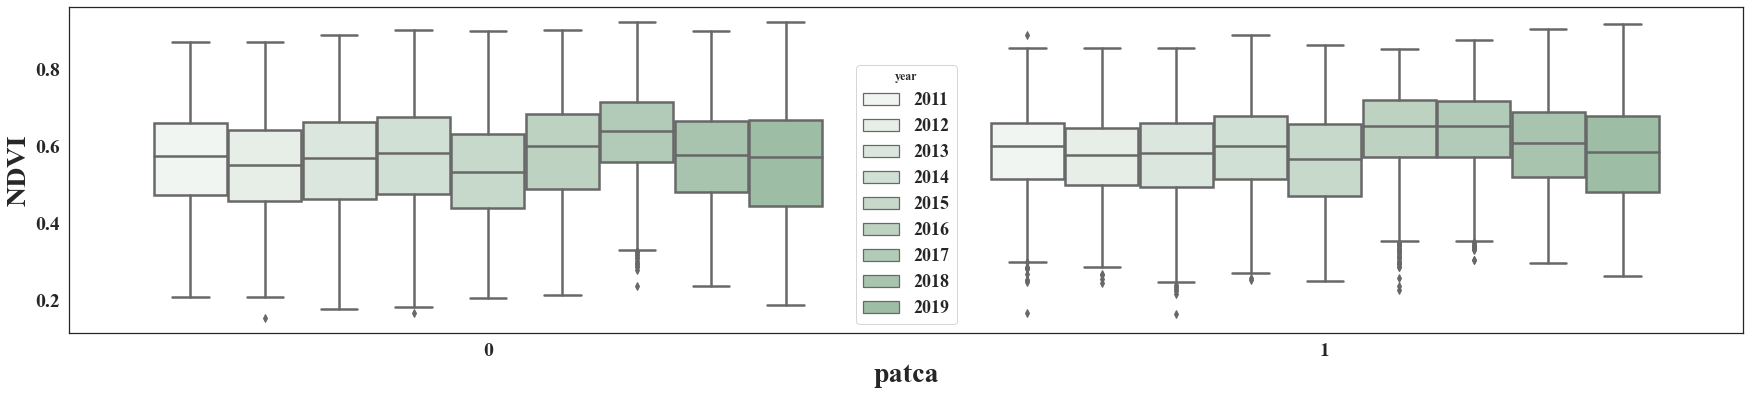

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='patca', y='NDVI',hue = "year", data=merge, color='#99c2a2')
# ax = sns.swarmplot(x='patca', y='NDVI', data=merge, color='#7d0013')
plt.show()

In [10]:
merge.date.dt.year

date
2011-01-31    2011
2011-02-28    2011
2011-03-31    2011
2011-04-30    2011
2011-05-31    2011
              ... 
2019-07-31    2019
2019-08-31    2019
2019-10-31    2019
2019-11-30    2019
2019-12-31    2019
Name: date, Length: 35948, dtype: int64